<a href="https://colab.research.google.com/github/ROPDIS/Models/blob/main/VGG16_BatchSize_32_Section5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Load the dependencies


In [ ]:
import numpy as np
import torch
import cv2 as cv2
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import os
from pathlib import Path
import glob
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC

Step 2: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")




Mounted at /content/gdrive


Step 3: Import Images

In [ ]:
train_path = Path("/content/gdrive/MyDrive/Dis/Training Set Thumbnails")
test_path= Path("/content/gdrive/MyDrive/Dis/TestSetThumbnails")

test = Path('/content/gdrive/MyDrive/')







Training Data

In [ ]:
train_paths = list(train_path.glob(r"**/*.jpg"))




Testing Set

In [ ]:
test_paths = list(test_path.glob(r"**/*.jpg"))



Image Pre-processing


In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(60,80),
                                        batch_size=32,
                                        class_mode='binary')


Found 17970 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(test_path, batch_size = 32,target_size=(60,80),class_mode='binary')

Found 1742 images belonging to 2 classes.


Calculating F-score

In [ ]:
def f_score(y_true, y_pred):
    true_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true, 0, 1)))
    predicted_positives = K.backend.sum(K.backend.round(K.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.backend.epsilon())
    recall = true_positives / (possible_positives + K.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.backend.epsilon())
    return f1_val

In [ ]:
# Custom Metric Functions
precision = Precision(name='precision')
recall = Recall(name='recall')
auc = AUC(name='auc')



CNN Model


In [ ]:
VGG = tf.keras.models.Sequential()

pretrained_model= tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(60,80,3),
    pooling=None)

for layer in pretrained_model.layers:
    layer.trainable = False

VGG.add(pretrained_model)

VGG.add(tf.keras.layers.Flatten())
VGG.add(BatchNormalization())  # Add BatchNormalization layer
VGG.add(tf.keras.layers.Dropout(0.2)) #Add Dropout Layer
VGG.add(tf.keras.layers.Dense(512, activation='relu'))
VGG.add(BatchNormalization())  # Add BatchNormalization layer
VGG.add(tf.keras.layers.Dropout(0.2)) #Add Dropout Layer
VGG.add(tf.keras.layers.Dense(1, activation='sigmoid'))

VGG.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              20

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer_adam=Adam(learning_rate=0.002)

VGG.compile(optimizer=optimizer_adam, loss='binary_crossentropy', metrics=[precision, recall, auc, 'accuracy',f_score])

In [ ]:
history = VGG.fit(
    training_set,
    validation_data=test_set,
    epochs=45,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=4
        )
    ]
)

Epoch 1/45
562/562 [==============================] - 3013s 5s/step - loss: 0.5189 - precision: 0.7762 - recall: 0.8001 - auc: 0.8356 - accuracy: 0.7673 - f_score: 0.7848 - val_loss: 0.7868 - val_precision: 0.9898 - val_recall: 0.5526 - val_auc: 0.8318 - val_accuracy: 0.5873 - val_f_score: 0.7052 - lr: 0.0020
Epoch 2/45
562/562 [==============================] - 122s 218ms/step - loss: 0.4564 - precision: 0.7995 - recall: 0.8192 - auc: 0.8669 - accuracy: 0.7913 - f_score: 0.8062 - val_loss: 0.7653 - val_precision: 0.9848 - val_recall: 0.5709 - val_auc: 0.8385 - val_accuracy: 0.6010 - val_f_score: 0.7180 - lr: 0.0020
Epoch 3/45
562/562 [==============================] - 134s 238ms/step - loss: 0.4509 - precision: 0.8040 - recall: 0.8238 - auc: 0.8705 - accuracy: 0.7963 - f_score: 0.8121 - val_loss: 0.6586 - val_precision: 0.9763 - val_recall: 0.6503 - val_auc: 0.8306 - val_accuracy: 0.6670 - val_f_score: 0.7781 - lr: 0.0020
Epoch 4/45
562/562 [==============================] - 139s 247m

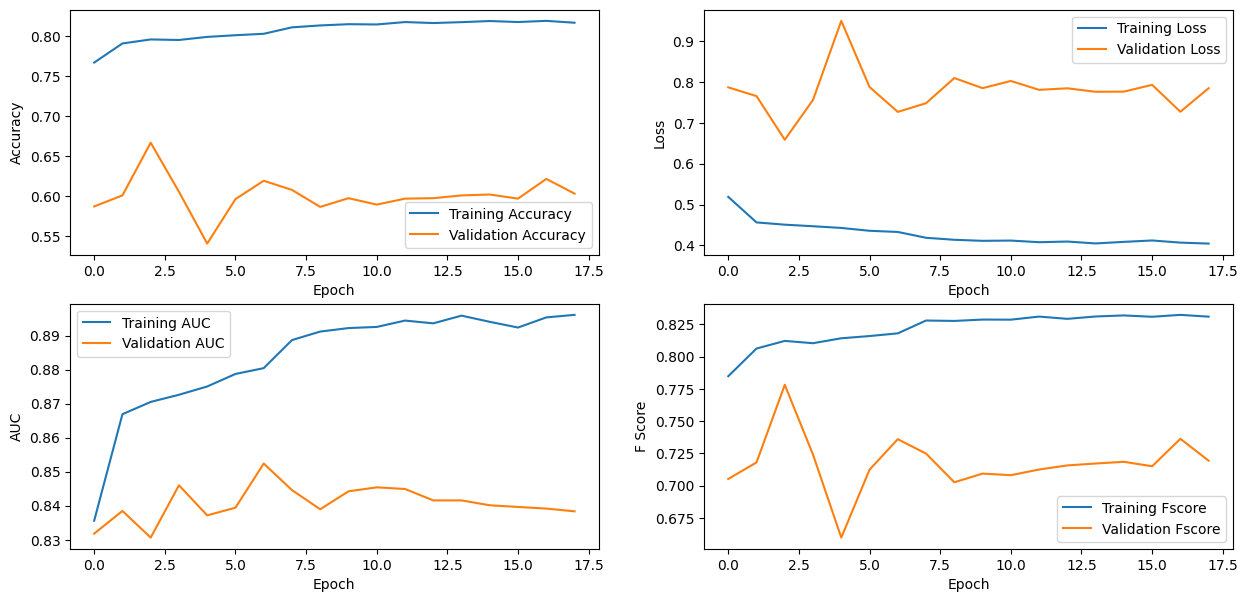

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 7))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.subplot(2, 2, 4)
plt.plot(history.history['f_score'], label='Training Fscore')
plt.plot(history.history['val_f_score'], label='Validation Fscore')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F Score')

plt.show()

55/55 [==============================] - 7s 115ms/step


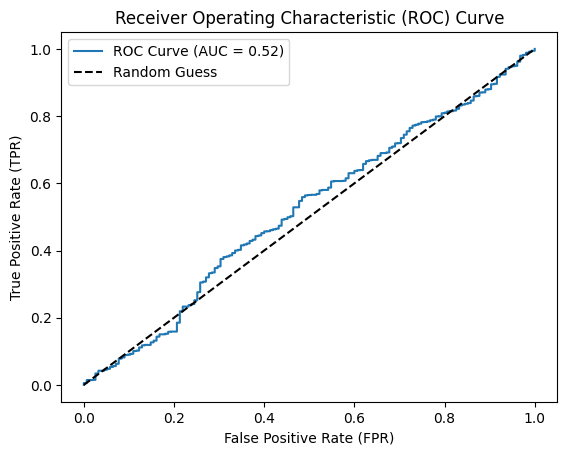

AUC: 0.519005223895766


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


# Make predictions on the test data
y_pred_prob = VGG.predict(test_set)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred = np.round(y_pred_prob).flatten()

# Get true target labels
y_true = test_set.classes

# Calculate the AUC
auc = roc_auc_score(y_true, y_pred_prob)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC
print("AUC:", auc)